# Your First Neural Network with JAX, Flax, and Optax (on MNIST)

Welcome! In this tutorial, we'll build a simple Multilayer Perceptron (MLP) to classify handwritten digits from the MNIST dataset, using the modern deep learning tools: **JAX** (for fast math), **Flax** (for neural network layers), and **Optax** (for optimization). We’ll also use PyTorch’s DataLoader for simplicity with data.

This will be your first code in JAX/Flax, so every section is explained in detail!

---

## 1. **Why JAX, Flax, and Optax?**

- **JAX**: Think of it as super-charged NumPy that can run on GPU/TPU and supports automatic differentiation (for gradients).
- **Flax**: A neural network library for JAX, similar to PyTorch's `torch.nn` or TensorFlow's Keras.
- **Optax**: A library of optimizers (like SGD, Adam) for use with JAX/Flax.


## Setup and Imports

In [ ]:
import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state


import optax

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import numpy as np

**Explanation:**
- `jax` and `jax.numpy` are for all mathematical operations (like NumPy, but faster and differentiable).
- `flax.linen` is where you'll define neural network layers and models.
- `flax.training.train_state` helps manage the model state (parameters, optimizer, etc).
- `optax` is used for optimization algorithms.
- `torch`, `torchvision.datasets`, and `DataLoader` are used to load and batch the MNIST data (since it’s easy and reliable).
- `numpy` is needed to convert data between PyTorch and JAX.


In [2]:
# 1. Download and prepare the MNIST dataset using PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),          # Converts image to tensor with values in [0, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 to 784 vector
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

**Explanation:**
- `transforms.ToTensor()` converts PIL images to PyTorch tensors (float32, [0,1]).
- `transforms.Lambda(...)` flattens each image from 28x28 to a vector of 784 elements.
- DataLoaders handle batching and shuffling.

---

In [4]:
# 2. **Define the MLP Model with Flax**


class MLP(nn.Module): #uses Flax.linen which is a high-level API for building neural networks and is similar to PyTorch's nn.Module
    """A simple Multi-Layer Perceptron (MLP) model."""
    features: list  # e.g., [128, 64, 10] for two hidden layers and 10 output classes

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]: # Iterate through all but the last feature size
            x = nn.Dense(feat)(x)   # nn.Dense creates a fully connected layer that maps input to output
            x = nn.relu(x)          # ReLU activation function allows the model to learn non-linear relationships
        x = nn.Dense(self.features[-1])(x)  # Output layer (no activation, logits) no activation function applied here because we want raw logits for classification

        return x


**Explanation:**
- `MLP` is a Flax model (inherits from `nn.Module`).
- `features` is a list defining the sizes of each layer (e.g., `[128, 64, 10]` means two hidden layers of 128 and 64 neurons, and output layer of size 10).
- `@nn.compact` tells Flax to use a concise way of defining the network in `__call__`.
- For each hidden layer, we apply a dense (fully connected) layer followed by `relu` activation.
- The final layer gives logits for the 10 digits (no activation).


# Initializing a training state

In [5]:
def create_train_state(rng, learning_rate, model):
    params = model.init(rng, jnp.ones([1, 784]))['params']  # initialize model parameters with a dummy input of shape [1, 784] (flattened MNIST image)
    # Create an optimizer using Optax, which is a gradient processing and optimization library for JAX.
    tx = optax.adam(learning_rate) # Adam optimizer with the specified learning rate
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx) # Create a TrainState object that holds the model parameters and optimizer state
    

**Explanation:**
- `rng` is a random number generator key (JAX is functional, so randomness is explicit!).
- `model.init(...)` initializes the model parameters (weights, biases) using a dummy input.
- `optax.adam` creates an Adam optimizer.
- `train_state.TrainState` is a helper class that bundles everything needed for training (parameters, optimizer, model function).


## Define the single Train Step and the Evalulation step that we will later use in loops

In [8]:
import functools

# @functools.partial(jax.jit, static_argnums=0) # JIT compilation for performance-- functools.partial allows us to create a new function with some arguments fixed.
@jax.jit
#here, we are fixing the first argument (the model) to be static, meaning it won't change during the execution of the function.
def train_step(state, batch_x, batch_y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_x) # Apply the model to the input batch_x using the current parameters
        onehot = jax.nn.one_hot(batch_y, 10) # Convert batch_y to one-hot encoding for 10 classes (0-9) using JAX's one_hot function
        loss = optax.softmax_cross_entropy(logits, onehot).mean() # Compute the softmax cross-entropy loss between the logits and the one-hot encoded labels
        return loss

    grads = jax.grad(loss_fn)(state.params) # Compute the gradients of the loss function with respect to the model parameters using JAX's automatic differentiation
    state = state.apply_gradients(grads=grads) # Update the model parameters using the computed gradients
    return state

#The evaluation step is similar to the training step, but it does not compute gradients or update the model parameters.
@jax.jit # JIT compilation for performance
def eval_step(state, batch_x):
    logits = state.apply_fn({'params': state.params}, batch_x) # Apply the model to the input batch_x using the current parameters
    return jnp.argmax(logits, axis=-1)

**Explanation:**
- `train_step`: Does one update of the network.
    - Computes predictions (logits), turns labels into one-hot vectors, computes cross-entropy loss.
    - Uses `jax.grad` to calculate gradients.
    - Updates parameters using the optimizer.
    - `@jax.jit` just-in-time compiles the function for speed.
- `eval_step`: Forwards data through the model and returns predicted classes.


## Training Loop

Epoch 1, Avg Train Loss: 0.3399, Test Accuracy: 0.9387
Epoch 2, Avg Train Loss: 0.1306, Test Accuracy: 0.9573
Epoch 3, Avg Train Loss: 0.0898, Test Accuracy: 0.9630
Epoch 4, Avg Train Loss: 0.0646, Test Accuracy: 0.9683
Epoch 5, Avg Train Loss: 0.0494, Test Accuracy: 0.9725


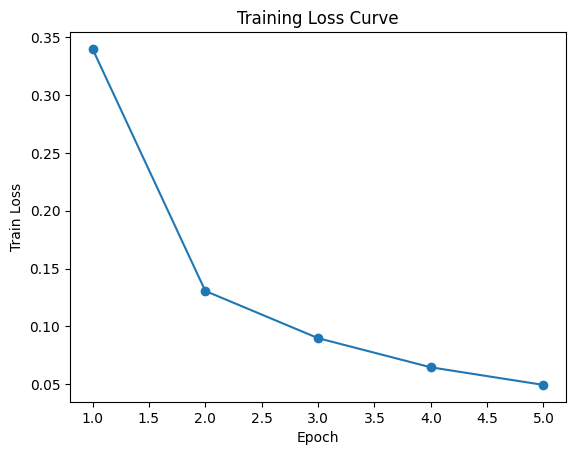

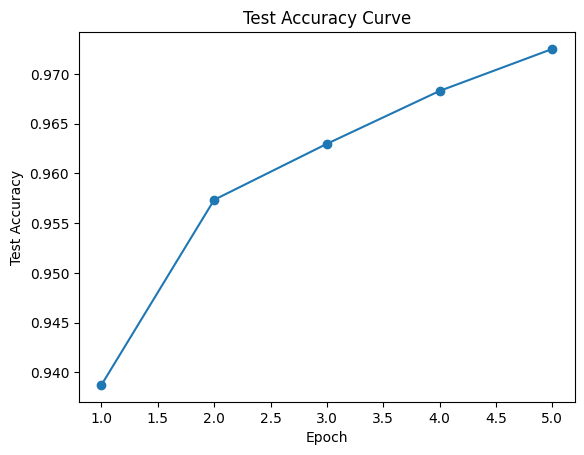

In [10]:
#simple way of training 

import matplotlib.pyplot as plt
from itertools import islice

rng = jax.random.PRNGKey(0)
mlp = MLP(features=[128, 64, 10])
state = create_train_state(rng, 1e-3, mlp)

train_losses = []
eval_accuracies = []

def compute_loss(state, batch_x, batch_y):
    logits = state.apply_fn({'params': state.params}, batch_x)
    onehot = jax.nn.one_hot(batch_y, 10)
    loss = optax.softmax_cross_entropy(logits, onehot).mean()
    return float(loss)

for epoch in range(5):
    epoch_loss = 0
    batch_count = 0
    # Training
    for batch_x, batch_y in train_loader:
        batch_x = np.array(batch_x.numpy())
        batch_y = np.array(batch_y.numpy())
        state = train_step(state, batch_x, batch_y)
        loss = compute_loss(state, batch_x, batch_y)
        epoch_loss += loss
        batch_count += 1
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation
    correct = 0
    total = 0
    for batch_x, batch_y in islice(test_loader, 50):  # check 50 batches
        batch_x = np.array(batch_x.numpy())
        batch_y = np.array(batch_y.numpy())
        preds = eval_step(state, batch_x)
        correct += (np.array(preds) == batch_y).sum()
        total += len(batch_y)
    acc = correct / total
    eval_accuracies.append(acc)
    print(f"Epoch {epoch+1}, Avg Train Loss: {avg_loss:.4f}, Test Accuracy: {acc:.4f}")

# Save loss curve
plt.figure()
plt.plot(range(1, 6), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Curve')
plt.savefig('train_loss_curve.png')

# Save evaluation (accuracy) curve
plt.figure()
plt.plot(range(1, 6), eval_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Curve')
plt.savefig('test_accuracy_curve.png')

# Training using TQDM Monitor (The Fun way of training!!)

In [9]:
import tqdm  # progress bar

from itertools import islice

rng = jax.random.PRNGKey(0)
mlp = MLP(features=[128, 64, 10])
state = create_train_state(rng, 1e-3, mlp)

for epoch in range(5):
    # Training
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = np.array(batch_x.numpy())  # PyTorch tensor to numpy
        batch_y = np.array(batch_y.numpy())
        state = train_step(state, batch_x, batch_y)
    # Evaluation
    correct = 0
    total = 0
    for batch_x, batch_y in islice(test_loader, 50):  # for speed, only check 50 batches
        batch_x = np.array(batch_x.numpy())
        batch_y = np.array(batch_y.numpy())
        preds = eval_step(state, batch_x)
        correct += (np.array(preds) == batch_y).sum()
        total += len(batch_y)
    print(f"Epoch {epoch+1}, Test Accuracy: {correct/total:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.96it/s]


Epoch 1, Test Accuracy: 0.9408


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.31it/s]


Epoch 2, Test Accuracy: 0.9559


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.69it/s]


Epoch 3, Test Accuracy: 0.9641


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.55it/s]


Epoch 4, Test Accuracy: 0.9677


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.99it/s]


Epoch 5, Test Accuracy: 0.9647


In [11]:
import numpy as np

# Example: Predict and compare actual labels for a batch from the test set

# Get a batch from the test_loader
batch_x, batch_y = next(iter(test_loader))
batch_x = np.array(batch_x.numpy())  # Convert PyTorch tensor to numpy
batch_y = np.array(batch_y.numpy())

# Run prediction using the trained model
preds = eval_step(state, batch_x)
preds = np.array(preds)  # Convert JAX array to numpy for easy comparison

# Print out predictions and actual labels side by side for the first 20 samples
print("Predicted | Actual")
print("------------------")
for i in range(20):
    print(f"{preds[i]:9d} | {batch_y[i]:6d}")

Predicted | Actual
------------------
        7 |      7
        2 |      2
        1 |      1
        0 |      0
        4 |      4
        1 |      1
        4 |      4
        9 |      9
        5 |      5
        9 |      9
        0 |      0
        6 |      6
        9 |      9
        0 |      0
        1 |      1
        5 |      5
        9 |      9
        7 |      7
        3 |      3
        4 |      4


# Understanding Batch Size, SGD, and Mini-batching in Neural Network Training

## What is Batch Size?

- **Batch size** is the number of samples processed before the model's parameters are updated once during training.
- It controls how much data is fed into the neural network at a time and directly affects memory usage and learning dynamics.

**In our MNIST example:**  
When we set `batch_size=128` in the DataLoader, each batch contains 128 images and their labels.

---

## SGD vs. Mini-batch SGD vs. Batch Gradient Descent

- **Stochastic Gradient Descent (SGD):**
  - Updates model parameters after **every single training sample**.
  - Implies `batch_size = 1`.
  - Noisy updates, rarely used in deep learning.

- **Mini-batch SGD:**
  - Updates model parameters after every small batch of samples (e.g., 32, 64, 128).
  - The most common method in deep learning.
  - Balances memory efficiency, update stability, and convergence speed.
  - **Our code uses mini-batch SGD with batch size 128.**

- **Batch Gradient Descent:**
  - Uses the **entire dataset as a single batch** (`batch_size = dataset size`).
  - Updates parameters only once per epoch, less common due to high memory usage.

---

## Where is Batch Size Used in the Training Process?

- The **train DataLoader** divides the dataset into batches of the specified size (e.g., 128).
- In each training iteration, the model computes the loss and gradients using one batch and updates its parameters.
- This is why you see code that loops through the `train_loader`, and each loop processes one batch.

---

## Evaluation Batch Size and Subsampling

- The **test DataLoader** also uses `batch_size=128`, so evaluation is done in chunks of 128 samples.
- In the provided code, only the **first 50 batches** of the test set are used for evaluation during training:
  - This means only `50 batches × 128 samples = 6,400` out of 10,000 test images are used for quick evaluation each epoch.
  - This is done for speed and quick feedback during training.
  - **For a real evaluation, you should use the entire test set** by looping over all batches in the test DataLoader.

---

## Summary Table

| Loader        | Batch Size | # Batches Used    | Samples Evaluated         | Purpose                       |
|---------------|------------|-------------------|---------------------------|-------------------------------|
| Training      | 128        | All               | All training samples      | Parameter updates (mini-batch)|
| Evaluation    | 128        | 50 (for speed)    | 6,400 out of 10,000       | Quick validation each epoch   |
| Evaluation    | 128        | All (recommended) | All 10,000 test samples   | Full validation               |

---

## Key Takeaways

- **Batch size** is a fundamental concept that controls how many samples are used for each parameter update.
- **SGD** (batch size 1) is mostly a theoretical baseline; in practice, **mini-batch SGD** (batch size > 1) is used for efficiency and better learning.
- Evaluating on a subset of data during training is for speed; always use the full dataset for final reporting.

**Explanation:**
- For each epoch, loop over all training batches and update the model.
- Convert PyTorch tensors to numpy arrays for JAX/Flax.
- On the test set, predict and compare with true labels, compute accuracy.
- `tqdm` shows a progress bar; `islice` is just to make evaluation faster for demonstration.

---

## 8. **What Did You Learn?**

- You built a neural network (MLP) from scratch using Flax + JAX + Optax.
- You used PyTorch DataLoader for easy data handling.
- You now understand:  
  - How to define a model in Flax  
  - How to manage state and optimizer  
  - The difference between train and eval steps  
  - How to batch data and run a training loop

---

## 9. **What’s Next?**

- Try changing the model architecture (more/less layers, different activations).
- Swap in a convolutional model (CNN) using `nn.Conv` and see if you get better results.
- Experiment with other datasets, batch sizes, optimizers, or learning rates!

---

**You are now ready for more advanced JAX/Flax experiments! 🚀**